In [1]:
using Distributions
using Random
using scBayesDeconv
using Plots

# Distribution 1

In [7]:
ndist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([10],ones(1,1)),
        MultivariateNormal([100],ones(1,1))
    ],
    [.5,.5]
    )

tdist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1))
    ],
    [1.]
    )

N = 1000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N)))+Matrix(transpose(rand(tdist,N)));
c = sort(c,dims=1);

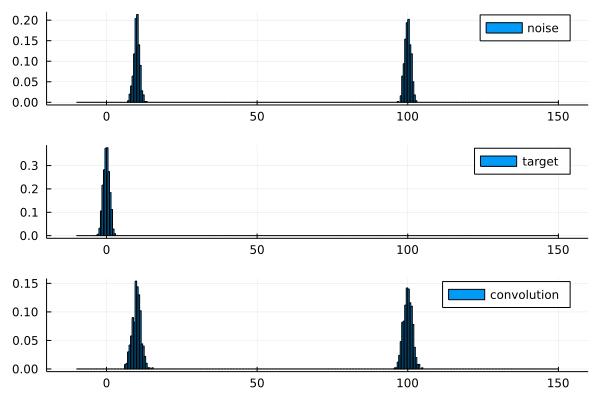

In [8]:
bins = range(-10,150,step=.5)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,150,step=.5)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target")

bins = range(-10,150,step=.5)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

plot(l1,l2,l3,layout=(3,1))

In [9]:
dn = infiniteGaussianMixture(n,k=2,Σ0 = ones(1,1),κ0=0.01);

In [10]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01,α=1);

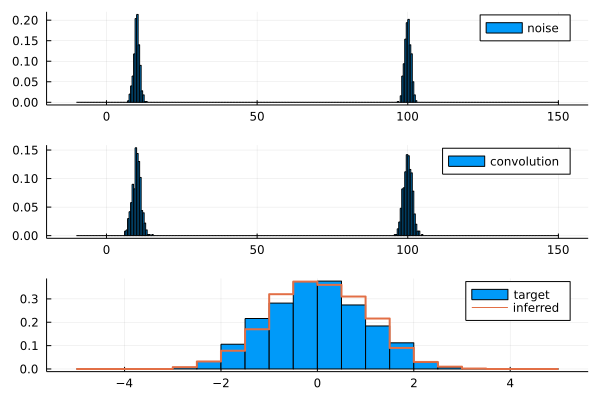

In [22]:
bins = range(-10,150,step=.5)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,150,step=.5)
l2 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

bins = range(-5,5,step=.5)
l3 = histogram(vec(t),normalize=true,bins=bins,label="target")
tt = rand(dt.samples[10],1000)
stephist!(l3,vec(tt),normalize=true,bins=bins,label="inferred",linewidth=2)

plot(l1,l2,l3,layout=(3,1))

# Distribution 2

In [46]:
tdist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1)),
        MultivariateNormal([3],ones(1,1))
    ],
    [.5,.5]
    )

ndist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1))
    ],
    [1.]
    )

N = 1000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N)))+Matrix(transpose(rand(tdist,N)));
c = sort(c,dims=1);

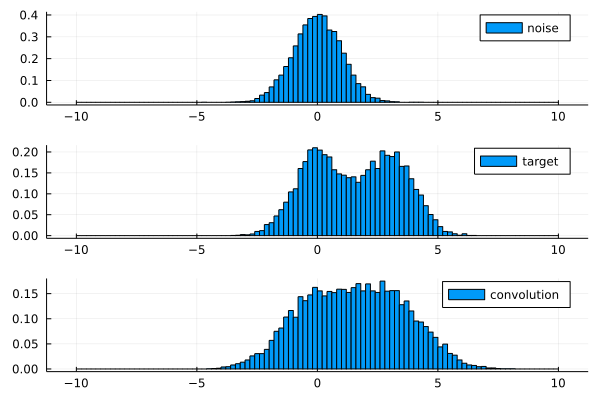

In [48]:
bins = range(-10,10,step=.2)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,10,step=.2)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target")

bins = range(-10,10,step=.2)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

plot(l1,l2,l3,layout=(3,1))

In [49]:
dn = infiniteGaussianMixture(n,k=2,Σ0 = ones(1,1),κ0=0.01);

In [50]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01,α=1);

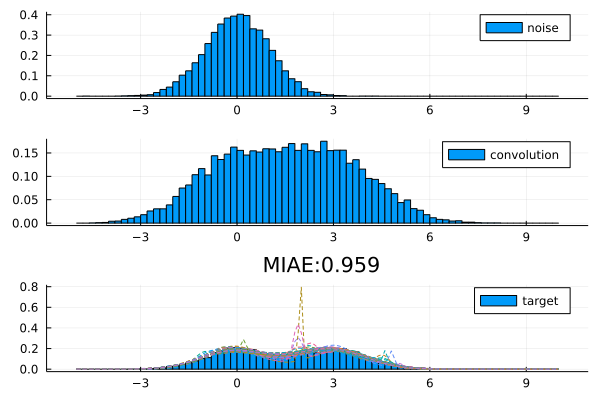

In [75]:
x = -5:.1:10

bins = range(-5,10,step=.2)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-5,10,step=.2)
l2 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

f1(x) = pdf(tdist,x)
miae = []
for k in 2:10:100
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-10. 10.],.5))
end

bins = range(-5,10,step=.2)
l3 = histogram(vec(t),normalize=true,bins=bins,label="target")

for k in 2:1:100
    y = ([pdf(dt.samples[k],[j]) for j in x])
    plot!(l3,x,y,style=:dash,label=nothing,title=string(" MIAE:",round(mean(miae),digits=3)))
end

plot(l1,l2,l3,layout=(3,1))

# Distribution 3

In [2]:
tdist = MixtureModel([
    product_distribution([Gamma(3,2),Gamma(2,3)]),
    product_distribution([Gamma(5,1),Gamma(7,7)]),
    product_distribution([Gamma(10,1.5),Gamma(10,7)]),
]
)

ndist = MixtureModel(
    [
        product_distribution([Gamma(3,2),Gamma(2,3)])
    ],
    [1.]
    )

N = 1000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N))).+Matrix(transpose(rand(tdist,N)));

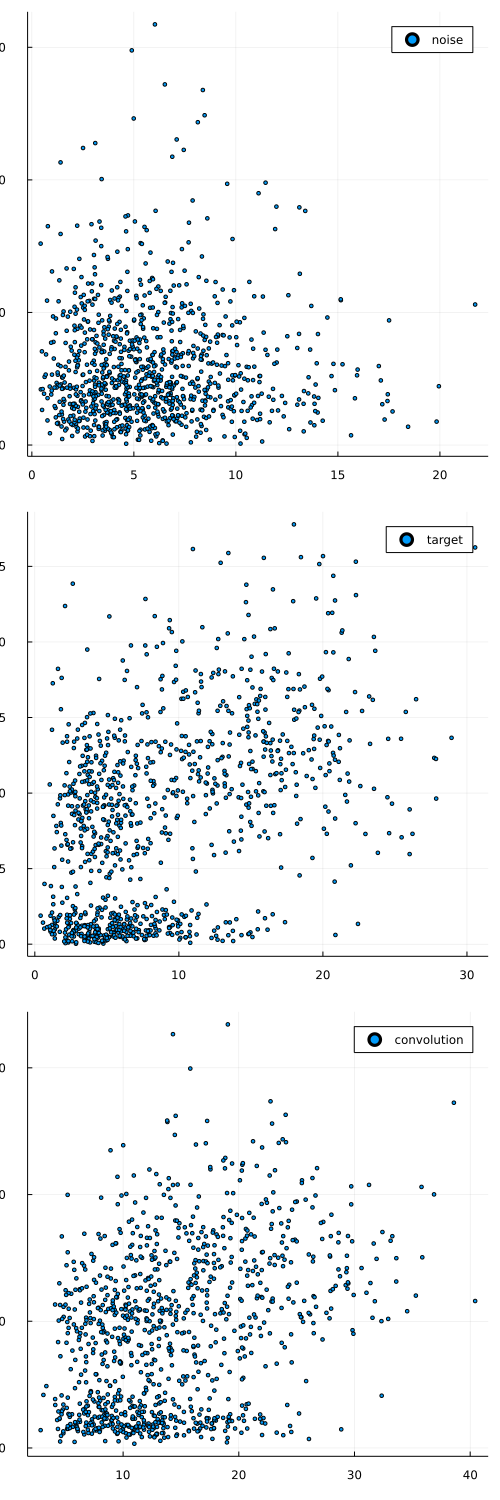

In [3]:
l1 = scatter(n[:,1],n[:,2],markersize=2,label="noise")

l2 = scatter(t[:,1],t[:,2],markersize=2,label="target")

l3 = scatter(c[:,1],c[:,2],markersize=2,label="convolution")

plot(l1,l2,l3,layout=(3,1),size=[500,1500])

In [4]:
dn = infiniteGaussianMixture(n,k=2,κ0=0.01);

In [5]:
function infiniteGaussianMixtureDeconvolution(X::Matrix, Y::GaussianInfiniteMixtureModel;
    k = 1,
    initialization::Union{String,Matrix} = "kmeans",
    α = 1,
    ν0 = size(X)[2]+1,
    κ0 = 0.001,
    μ0 = nothing,
    Σ0 = nothing,
    ignoreSteps::Int = 1000, 
    saveSteps::Int = 1000,
    saveEach::Int = 10,
    verbose = false,
    seed = 0
    )

    Random.seed!(seed)

    nCells, dimensions = size(X)

    #Activate progress line
    if verbose 
        ProgressMeter.ijulia_behavior(:clear)
        prog = Progress(length(ignoreSteps+saveSteps))
    end 

    #Initialization
    centers,covariances,weights,identities = scBayesDeconv.initializationGaussianMixture(X,k,initialization)
    #Hyperparameters
    μ0,Σ0 = scBayesDeconv.initializationGaussianMixtureHyperparameters(X,μ0,Σ0)

    #Auxiliar functions
    vote = fill(0,k) #Auxiliar for sampling from the Dirichlet distributions

    saveIds = Vector{Int}[]
    saveDist = MixtureModel[]
    saveN = Int[]

    nSamples = length(Y.samples)
    nRange = range(1,nSamples,step=1)
    centersN = [i.μ for i in Y.samples[1].components]
    covariancesN = [i.Σ for i in Y.samples[1].components]
    weightsN = Y.samples[1].prior.p
    identitiesN = copy(identities)

    #Loop
    for step in 1:(ignoreSteps+saveSteps)

        #Sample noise distribution
        nSample = rand(nRange)
        centersN = [i.μ for i in Y.samples[nSample].components]
        covariancesN = [i.Σ for i in Y.samples[nSample].components]
        weightsN = Y.samples[nSample].prior.p        
        kT = length(centers)
        kN = length(centersN)
        p = zeros(nCells,kT*kN)
        w = zeros(kT*kN+kN)
        
        #Statistics
        m = fill(zeros(dimensions),kN,kT)
        S2 = fill(zeros(dimensions,dimensions),kN,kT)
        n = zeros(Int,kN,kT)

        #Sample new noise identities
        scBayesDeconv.gmlikelihoodConvolution!(p,X,centers,covariances,weights,centersN,covariancesN,weightsN)
        for i in 1:nCells           
            vote = rand(Multinomial(1,@views(p[i,:])))
            pos = scBayesDeconv.lin2cartesian(findfirst(vote.==1),kN,kT)
            # identities[i] = pos[2]
            identitiesN[i] = pos[1]
            n[pos[1],identities[i]] += 1 #Keep target base, but change noise base
        end

        #Effective parameters
        m0 = zeros(kN,kT)
        m1 = zeros(kN,kT)
        νeff = zeros(kN,kT)
        μyeff = fill(zeros(dimensions),kN,kT)
        Σyeff = fill(zeros(dimensions,dimensions),kN,kT)

        #Compute statistics
        for j in 1:kN
            for k in 1:kT
                ids = (identities .== k) .& (identitiesN .== j)
                if sum(ids) != 0
                    m[j,k] = reshape(mean(@views(X[ids,:]),dims=1),dimensions)
                    S2[j,k] = cov(@views(X[ids,:]),dims=1,corrected=false)
                end
                m0[j,k] = (n[j,k]+κ0)/(n[j,k]+κ0+1)
                m1[j,k] = ((n[j,k]*κ0)/(n[j,k]+κ0)+n[j,k]*κ0)/(n[j,k]+κ0+1)
                νeff[j,k] = (n[j,k]+ν0+1-dimensions)
                μyeff[j,k] = (n[j,k]*m[j,k]+κ0*μ0)/(n[j,k]+κ0)
                aux = (m1[j,k]*(μ0-m[j,k])*transpose(μ0-m[j,k])+n[j,k]*S2[j,k]+Σ0)/m0[j,k]
                Σyeff[j,k] = (aux+transpose(aux))/2
            end
        end

        # println("S2",S2,"\n Σyeff",Σyeff,"\n m1",m1,"\n m0",m0,"\n")

        for i in 1:nCells           

            id = identities[i]
            idN = identitiesN[i]

            #Remove sample
            # println(n,sum(n,dims=1),n[idN,id],"/",sum(n),(idN,id))
            if sum(n[:,id]) == 1 #Remove component
                popat!(centers,id)
                popat!(covariances,id)
                popat!(weights,id)
                m = m[:,id .!= 1:kT]
                S2 = S2[:,id .!= 1:kT]
                n = n[:,id .!= 1:kT]
                w = w[1:end-kN]
                m0 = m0[:,id .!= 1:kT]
                m1 = m1[:,id .!= 1:kT]
                νeff = νeff[:,id .!= 1:kT]
                μyeff = μyeff[:,id .!= 1:kT]
                Σyeff = Σyeff[:,id .!= 1:kT]
                identities[identities.>id] .-= 1 #Reduce index of components above the removed one
                kT -= 1
                # println("Component removed")
            else #Modify statistics
                #Statistics
                if n[idN,id] == 1
                    mnew = zeros(dimensions)
                    S2[idN,id] .= 0
                else
                    mnew = (n[idN,id]*m[idN,id]-X[i,:])/(n[idN,id]-1)
                    S2[idN,id] .= (n[idN,id]*S2[idN,id] + n[idN,id]*m[idN,id]*transpose(m[idN,id]) - X[i,:]*transpose(X[i,:]))/(n[idN,id]-1) - mnew*transpose(mnew)
                end
                m[idN,id] .= mnew
                n[idN,id] -= 1 
                #Effective parameters
                m0[idN,id] = (n[idN,id]+κ0)/(n[idN,id]+κ0+1)
                m1[idN,id] = ((n[idN,id]*κ0)/(n[idN,id]+κ0)+n[idN,id]*κ0)/(n[idN,id]+κ0+1)
                νeff[idN,id] = n[idN,id]+ν0+1-dimensions
                μyeff[idN,id] = (n[idN,id]*m[idN,id]+κ0*μ0)/(n[idN,id]+κ0)
                Σyeff[idN,id] = (m1[idN,id]*(μ0-m[idN,id])*transpose(μ0-m[idN,id])+n[idN,id]*S2[idN,id]+Σ0)/m0[idN,id]
                Σyeff[idN,id] = (Σyeff[idN,id]+transpose(Σyeff[idN,id]))/2 #Solve problem with hermitian
            end

            #Reassign sample
            for j in 1:kN
                for k in 1:kT
                    try
                        w[scBayesDeconv.cartesian2lin(j,k,kN,kT+1)] = logpdf(MvTDist(νeff[j,k],μyeff[j,k],Σyeff[j,k]/νeff[j,k]),@views(X[i,:]))+log(n[j,k]/(nCells+α-1))
                    catch
                        error((j,k,scBayesDeconv.cartesian2lin(j,k,kN,kT+1)),"\n S2",S2,"\n Σyeff",Σyeff,"\n m1",m1,"\n m0",m0,"\n")
                    end
                end
                w[scBayesDeconv.cartesian2lin(j,kT+1,kN,kT+1)] = logpdf(MultivariateNormal(μ0+centersN[kN],Σ0+covariancesN[kN]),@views(X[i,:]))+log(α/(nCells+α-1))
            end
            w .-= maximum(w)
            w = exp.(w)
            w ./= sum(w)
            vote = rand(Multinomial(1,w))
            aux = scBayesDeconv.lin2cartesian(findfirst(vote.==1),kN,kT+1)
            identities[i] = aux[2]
            identitiesN[i] = aux[1]

            #Update statistics
            id = identities[i]
            idN = identitiesN[i]
            if id == kT + 1 #Add component
                # println("Component added")
                # Add new data
                m = hcat(m,fill(X[i,:],kN,1))
                S2 = hcat(S2,fill(zeros(dimensions,dimensions),kN,1))
                n = hcat(n,fill(0,kN))
                centers = push!(centers,copy(μ0))
                covariances = push!(covariances,copy(Σ0))
                weights = push!(weights,1/nCells)
                append!(w,zeros(kN))
                m0 = hcat(m0,fill(0,kN))
                m1 = hcat(m1,fill(0,kN))
                νeff = hcat(νeff,fill(0,kN))
                μyeff = hcat(μyeff,fill(zeros(dimensions),kN,1))
                Σyeff = hcat(Σyeff,fill(zeros(dimensions,dimensions),kN,1))

                k = id
                n[idN,id] += 1
                for j in 1:kN
                    ids = (identities .== k) .& (identitiesN .== j)
                    if sum(ids) != 0
                        m[j,k] = reshape(mean(@views(X[ids,:]),dims=1),dimensions)
                        S2[j,k] = cov(@views(X[ids,:]),dims=1,corrected=false)
                    end
                    m0[j,k] = (n[j,k]+κ0)/(n[j,k]+κ0+1)
                    m1[j,k] = ((n[j,k]*κ0)/(n[j,k]+κ0)+n[j,k]*κ0)/(n[j,k]+κ0+1)
                    νeff[j,k] = (n[j,k]+ν0+1-dimensions)
                    μyeff[j,k] = (n[j,k]*m[j,k]+κ0*μ0)/(n[j,k]+κ0)
                    aux = (m1[j,k]*(μ0-m[j,k])*transpose(μ0-m[j,k])+n[j,k]*S2[j,k]+Σ0)/m0[j,k]
                    Σyeff[j,k] = (aux+transpose(aux))/2
                end
        
                # println("----S2",S2,"\n Σyeff",Σyeff,"\n m1",m1,"\n m0",m0,"\n")

                kT += 1
            else #Modify statistics
                #Statistics
                mnew = (n[idN,id]*m[idN,id]+X[i,:])/(n[idN,id]+1)
                S2[idN,id] = (n[idN,id]*S2[idN,id] + n[idN,id]*m[idN,id]*transpose(m[idN,id]) + X[i,:]*transpose(X[i,:]))/(n[idN,id]+1) - mnew*transpose(mnew)
                m[idN,id] .= mnew
                n[idN,id] += 1
                #Effective parameters
                m0[idN,id] = (n[idN,id]+κ0)/(n[idN,id]+κ0+1)
                m1[idN,id] = ((n[idN,id]*κ0)/(n[idN,id]+κ0)+n[idN,id]*κ0)/(n[idN,id]+κ0+1)
                νeff[idN,id] = n[idN,id]+ν0+1-dimensions
                μyeff[idN,id] = (n[idN,id]*m[idN,id]+κ0*μ0)/(n[idN,id]+κ0)
                Σyeff[idN,id] = (m1[idN,id]*(μ0-m[idN,id])*transpose(μ0-m[idN,id])+n[idN,id]*S2[idN,id]+Σ0)/m0[idN,id]
                Σyeff[idN,id] = (Σyeff[idN,id]+transpose(Σyeff[idN,id]))/2 #Solve problem with hermitian
            end

        end

        #Save
        if step >= ignoreSteps && step%saveEach == 0

            push!(saveN,nSample)

        #Sample parameters
            #Sample weights
            votesK = reshape(sum(n,dims=1),kT)
            weights .= rand(Dirichlet(votesK.+α/k))
            for comp in 1:kT
                idsT = identities.==comp
    
                if votesK[comp] > dimensions #Check if we have enough statistical power to compute the wishart  
    
                    #Sample covariance
                    m2 = zeros(dimensions,dimensions)
                    S2 = zeros(dimensions,dimensions)
                    for compN in 1:kN
                        idsN = identitiesN.==compN
                        ids = idsN .& idsT
                        #Statistics
                        if sum(ids) > 0
                            aux = (reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN]-centers[comp])
                            m2 .+= n[compN,comp]*aux*transpose(aux)
                            S2 .+= n[compN,comp]*(cov(@views(X[ids,:]),corrected=false)-covariancesN[compN])
                        end
                    end
                    # println(votes,m/votesK[comp],S2/votesK[comp])
                    for i in 1:dimensions
                        if S2[i,i] < 0
                            S2[i,i] = 0
                        end
                    end
                    neff = votesK[comp]+ν0+1
    
                    Σeff = S2 + m2 + κ0*(centers[comp]-μ0)*transpose((centers[comp]-μ0)) + Σ0
                    # println(S2, m2, κ0*(centers[comp]-μ0)*transpose((centers[comp]-μ0)), Σ0)
                    Σeff = (Σeff+transpose(Σeff))/2 #Reinforce hermicity
                    try
                        covariances[comp] = rand(InverseWishart(neff,Σeff))
                    catch
                        println("WARNING: Sampling has failed for this covariance matrix. In general this will not be a problem if only happens in rare ocassions.")
                    end
                    #Sample centers
                    m = zeros(dimensions)
                    S2 = zeros(dimensions,dimensions)
                    for compN in 1:kN
                        idsN = identitiesN.==compN
                        ids = idsN .& idsT
                        s = inv(covariances[comp]+covariancesN[compN])
                        #Statistics
                        # println((votes[cartesian2lin(comp,compN,k,kN)]*(reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN])+κ0*μ0))
                        if sum(ids) > 0
                            m .+= s*(n[compN,comp]*(reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN])+κ0*μ0)
                            S2 .+= s*(n[compN,comp]+κ0)
                        end
                    end
                    S2 = inv(S2)
                    S2 = (transpose(S2)+S2)/2
                    m = S2*m
                    centers[comp] .= rand(MultivariateNormal(m,S2))
    
                end
            end
    
            #rel = relabeling(identities,identitiesRef)
            dist = MixtureModel(MultivariateNormal[[MultivariateNormal(copy(i),copy(j)) for (i,j) in zip(centers,covariances)]...],copy(weights))
            push!(saveDist,deepcopy(dist))
            push!(saveIds,copy(identities))
            
        end

        #Show progress bar if verbose
        if verbose
            next!(prog,showvalues=[(:iter,step)])
        end

    end

    return GaussianInfiniteMixtureModelDeconvolved(
                                Dict([  
                                        :α=>α,
                                        :ν0 => ν0,
                                        :κ0 => κ0,
                                        :μ0 => μ0,
                                        :Σ0 => Σ0
                                    ]),
                                saveDist,
                                saveIds,
                                saveN,
                                Y
                                )

end

infiniteGaussianMixtureDeconvolution (generic function with 1 method)

In [6]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,κ0=0.001,k=1,α=1);

[0.0 241.13866866368184; 241.13866866368184 103.43985506736794][982.8526605342956 3087.4321399478104; 3087.4321399478104 9698.541400499264][0.0001033462635440576 -0.007432462956687403; -0.007432462956687403 0.5345283294057401][46.344900058828415 80.15332162163924; 80.15332162163924 1011.1039081536748]
[1029.1976639393877 3408.716697770175; 3408.716697770175 10813.619692049713]


[4.623301573367172 328.3672354205273; 328.3672354205273 987.3730865002366][435.4429501207885 1703.637870865618; 1703.6378708656182 6928.404136723297][0.0 0.0; 0.0 0.0][46.344900058828415 80.15332162163924; 80.15332162163924 1011.1039081536748]
[486.4111517529841 2112.1584279077847; 2112.1584279077847 8926.881131377208]


[18.644536305973475 623.7657763814512; 623.7657763814512 3537.2891801662204][4.623298950462081 80.8758069588348; 80.8758069588348 1414.7681604255713][0.0 0.0; 0.0 0.0][46.344900058828415 80.15332162163924; 80.15332162163924 1011.1039081536748]
[69.61273531526396 784.7949049619253; 784.7949049619253 5963.161248745466]


[0.0 278.0262375053943; 278.0262375053943 0.0][66.70824817966397 261.145483910423; 261.145483910423 1022.3168143036155][0.0 0.0; 0.0 0.0][46.344900058828415 80.15332162163924; 80.15332162163924 1011.1039081536748]
[113.05314823849238 619.3250430374565; 619.3250430374565 2033.4207224572901]


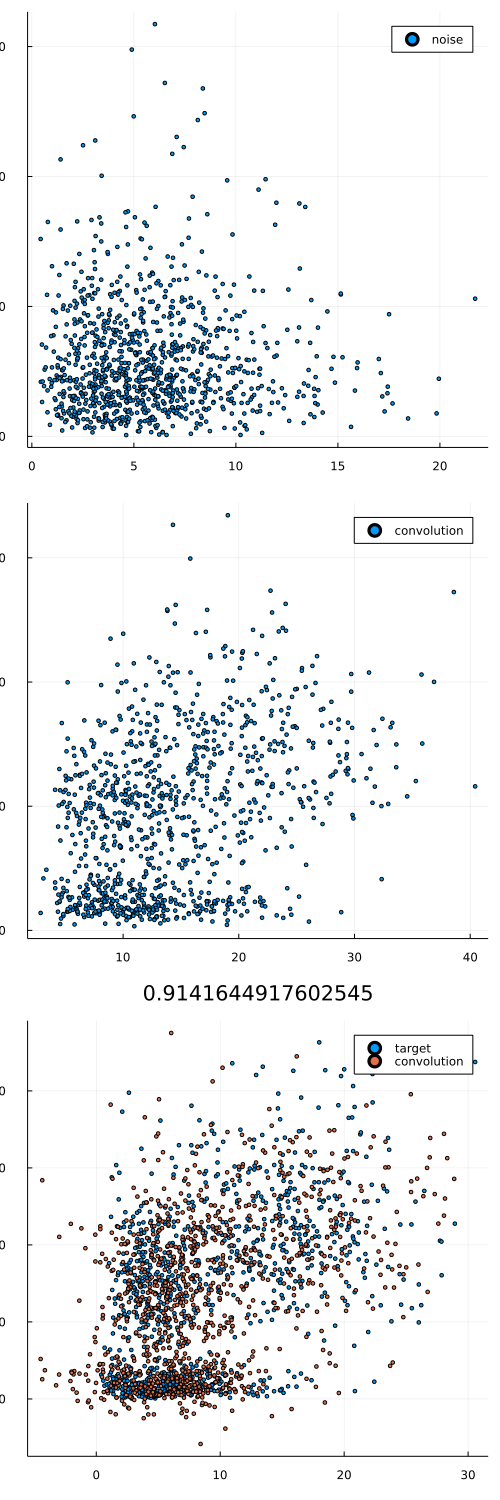

In [24]:
l1 = scatter(n[:,1],n[:,2],markersize=2,label="noise")

l3 = scatter(c[:,1],c[:,2],markersize=2,label="convolution")

f1(x) = pdf(tdist,x)
miae = []
for k in 2:10:100
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-10. 10.;-10 10],.1))
end

s = rand(dt.samples[10],1000)
l2 = scatter(t[:,1],t[:,2],markersize=2,label="target")
scatter!(l2,s[1,:],s[2,:],markersize=2,label="convolution",title=string("MIAE",mean(miae)))

plot(l1,l3,l2,layout=(3,1),size=[500,1500])